In [757]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from skimage import io, morphology, img_as_bool, segmentation
from scipy import ndimage as ndi
from scipy.ndimage.morphology import binary_fill_holes

%matplotlib inline

In [758]:
img_shape = (64,64)

In [759]:
def pad_resize(img):
    top = int((224 - img.shape[0])/2)
    left = int((224 - img.shape[1])/2)
    bottom = 224 - img.shape[0] - top
    right = 224 - img.shape[1] - left
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=255)
    img = img/255.
    img = cv2.resize(img, img_shape) #KADD
    return img

def skeletonize(img):
    size = np.size(img)
    skel = np.zeros(img.shape,np.uint8)
    img = cv2.bitwise_not(img)
#     element = cv2.getStructuringElement(cv2.MORPH_CROSS,(1,1))
#     done = 0
#     while( done < 1 ):
#         eroded = cv2.erode(img,element)
#         temp = cv2.dilate(eroded,element)
#         temp = cv2.subtract(img,temp)
#         skel = cv2.bitwise_or(skel,temp)
#         img = eroded.copy()

#         zeros = size - cv2.countNonZero(img)
#         if zeros==size:#cv2.countNonZero(img) * 1 >= 0:#
#             done += 1
#     img = skel
    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.erode(img,kernel,iterations = 2)
    img = cv2.bitwise_not(erosion)
    return img

In [760]:
PATH = '../train_images_modified'
images = []
base_class = []
matra_class = []
dot_class = []
total_class = []
for filename in os.listdir(PATH):
    if filename.endswith(".png"):
        img = cv2.imread(os.path.join(PATH,filename),0)
        blur = cv2.GaussianBlur(img,(9,9),0)# KADD
        a,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)#KEDIT
#         kernel = np.ones((5,5),np.uint8)
#         img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
#         plt.imshow(img, cmap='gray')
#         plt.show()
#        img = skeletonize(img)
        img = pad_resize(img)
        blur = cv2.GaussianBlur(img,(9,9),0)# KADD
        char_arr = filename[:-4].split('_')[3:]
        if(len(char_arr)>0):
            char_arr = [int(i) for i in char_arr]
            base = [i for i in char_arr if (i>=2308 and i<=2361) or (i==2384) or (i>=2392 and i<=2401) or (i>=2404 and i!=2416 and i!=2417)]  
            matra = [i for i in char_arr if i>=2362 and i<=2391 and i!=2364 and i!=2362]
            dot = [i for i in char_arr if i==2306 or i==2416 or i==2362 or i==2364]
            if(len(matra)>1 or len(dot)>1 or len(base)>1 or (len(matra)==0 and len(dot)==0 and len(char_arr)==2)):
                print(filename+" dropped!")
            else:
                images.append(img)
                base_class.append(base[0])
                if(len(matra)==1):
                    matra_class.append(matra[0])
                else:
                    matra_class.append(0)

                if len(dot)==1:
                    if dot[0] == 2364:
                        dot_class.append(2)
                    else:
                        dot_class.append(1)
                else:
                    dot_class.append(0)

                if len(images)%100==0:
                    print("{} Done".format(len(images)))
            

100 Done
page0_8_8_2330_2375_2379.png dropped!
page0_9_15_2332_2375_2379.png dropped!
200 Done
300 Done
400 Done
500 Done
600 Done
page2_4_20_2346_2366_2390.png dropped!
700 Done
page3_12_0_2357_2364_2416.png dropped!
800 Done
page3_18_4_2332_2366_2379.png dropped!
900 Done
page3_6_0_2327_2417.png dropped!
1000 Done
1100 Done
1200 Done
1300 Done
page5_7_8_2325_2367_2388.png dropped!
1400 Done
page6_10_6_2325_2366_2380.png dropped!
1500 Done
page6_1_1_2340_2375_2379.png dropped!
1600 Done
1700 Done
page7_16_10_2350_2417.png dropped!
1800 Done
page7_3_0_2319_2366_2367.png dropped!
page7_3_13_2319_2366_2367.png dropped!


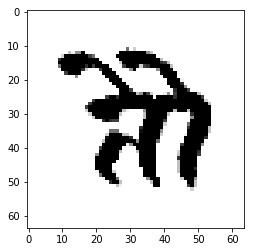

1883
1883


In [761]:
plt.imshow(images[10],"gray")
plt.show()
print(len(images))
print(len(dot_class))

In [762]:
len(set(base_class))
freq = {i:base_class.count(i) for i in base_class}
[i for i in freq.keys() if freq[i]==1]

[2392, 2353, 2310, 2384, 2415, 2414]

In [763]:
images = np.array(images)
print(images.shape)

(1883, 64, 64)


In [764]:
import keras
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

le = LabelEncoder()
le.fit(base_class)
y_labeled = le.transform(base_class)
y_train = np_utils.to_categorical(y_labeled)
print(y_train.shape)

(1883, 53)


In [765]:
x_train = np.reshape(images,(-1,img_shape[0],img_shape[1],1))
print(x_train.shape)

(1883, 64, 64, 1)


In [766]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten
from keras.optimizers import Adam

base_model = Sequential()

base_model.add(Conv2D(16,(3,3),input_shape = (img_shape[0],img_shape[1],1),activation = 'relu'))
base_model.add(Conv2D(16,(3,3),activation = 'relu'))
base_model.add(MaxPooling2D())
base_model.add(Conv2D(32,(3,3),activation = 'relu'))
base_model.add(Conv2D(32,(3,3),activation = 'relu'))
base_model.add(MaxPooling2D())
base_model.add(Conv2D(64,(3,3),activation = 'relu'))
base_model.add(Conv2D(64,(3,3),activation = 'relu'))
base_model.add(MaxPooling2D())
base_model.add(Flatten())
base_model.add(Dense(256,activation = 'sigmoid'))
base_model.add(Dropout(0.5))
base_model.add(Dense(len(set(base_class)),activation = 'softmax'))

In [767]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_140 (Conv2D)          (None, 62, 62, 16)        160       
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 28, 28, 32)        4640      
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 11, 11, 64)        18496     
__________

In [768]:
import keras.backend as K

def f1_score(theta):
    def score(y_true, y_pred):

        y_thresh = K.cast(K.greater(y_pred,theta),K.floatx())

        true_pos =  K.sum(y_true * y_thresh)
        false_pos = K.sum(y_true * (1. - y_thresh))
        false_neg = K.sum((1. - y_true) * y_thresh)

        precision = true_pos / (true_pos + false_pos)
        recall = true_pos / (true_pos + false_neg)
        
        f1_score_val = 2 * (precision * recall) / (precision + recall)
        return f1_score_val
    return score

In [769]:
base_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[f1_score(theta=0.5), 'categorical_accuracy'])

In [770]:
base_model.fit(x_train,y_train,epochs=40,batch_size=32,validation_split=0.3)

Train on 1318 samples, validate on 565 samples
Epoch 1/40
1318/1318 [==============================] - 21s 16ms/step - loss: 3.6166 - score: nan - categorical_accuracy: 0.0781 - val_loss: 3.5257 - val_score: nan - val_categorical_accuracy: 0.0885
Epoch 2/40
1318/1318 [==============================] - 18s 14ms/step - loss: 3.3816 - score: nan - categorical_accuracy: 0.0910 - val_loss: 3.5049 - val_score: nan - val_categorical_accuracy: 0.1150
Epoch 3/40
1318/1318 [==============================] - 17s 13ms/step - loss: 3.1320 - score: nan - categorical_accuracy: 0.1942 - val_loss: 3.0036 - val_score: nan - val_categorical_accuracy: 0.2637
Epoch 4/40
1318/1318 [==============================] - 18s 13ms/step - loss: 2.4822 - score: nan - categorical_accuracy: 0.3619 - val_loss: 2.5489 - val_score: nan - val_categorical_accuracy: 0.4106
Epoch 5/40
1318/1318 [==============================] - 17s 13ms/step - loss: 2.0912 - score: nan - categorical_accuracy: 0.4636 - val_loss: 2.2938 - val

KeyboardInterrupt: 

# DOT CLASS

In [771]:
y_train_dot = np_utils.to_categorical(dot_class)

In [772]:
dot_model = Sequential()

dot_model.add(Conv2D(16,(3,3),input_shape = (img_shape[0],img_shape[1],1),activation = 'relu'))
dot_model.add(Conv2D(16,(3,3),activation = 'relu'))
dot_model.add(MaxPooling2D())
dot_model.add(Conv2D(32,(3,3),activation = 'relu'))
dot_model.add(Conv2D(32,(3,3),activation = 'relu'))
dot_model.add(MaxPooling2D())
dot_model.add(Conv2D(64,(3,3),activation = 'relu'))
dot_model.add(Conv2D(64,(3,3),activation = 'relu'))
dot_model.add(MaxPooling2D())
dot_model.add(Flatten())
dot_model.add(Dense(256,activation = 'sigmoid'))
dot_model.add(Dropout(0.5))
dot_model.add(Dense(len(set(dot_class)),activation = 'softmax'))

dot_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[f1_score(theta=0.5), 'categorical_accuracy'])

dot_model.fit(x_train,y_train_dot,epochs=10,batch_size=32,validation_split=0.3)

Train on 1318 samples, validate on 565 samples
Epoch 1/10
1318/1318 [==============================] - 22s 17ms/step - loss: 0.2554 - score: 0.8867 - categorical_accuracy: 0.8930 - val_loss: 0.2140 - val_score: 0.9133 - val_categorical_accuracy: 0.9133
Epoch 2/10
1318/1318 [==============================] - 17s 13ms/step - loss: 0.1957 - score: 0.9340 - categorical_accuracy: 0.9340 - val_loss: 0.2118 - val_score: 0.9133 - val_categorical_accuracy: 0.9133
Epoch 3/10
1318/1318 [==============================] - 17s 13ms/step - loss: 0.1860 - score: 0.9340 - categorical_accuracy: 0.9340 - val_loss: 0.2111 - val_score: 0.9133 - val_categorical_accuracy: 0.9133
Epoch 4/10
1318/1318 [==============================] - 17s 13ms/step - loss: 0.1820 - score: 0.9336 - categorical_accuracy: 0.9332 - val_loss: 0.2114 - val_score: 0.9133 - val_categorical_accuracy: 0.9133
Epoch 5/10
1318/1318 [==============================] - 17s 13ms/step - loss: 0.1843 - score: 0.9340 - categorical_accuracy: 0.93

# MATRA CLASS

In [ ]:
le_matra = LabelEncoder()
le_matra.fit(matra_class)
y_labeled_matra = le_matra.transform(matra_class)
y_train_matra = np_utils.to_categorical(y_labeled_matra)

print(y_train_matra.shape)

(1883, 16)


In [ ]:
matra_model = Sequential()

matra_model.add(Conv2D(16,(3,3),input_shape = (img_shape[0],img_shape[1],1),activation = 'relu'))
matra_model.add(Conv2D(16,(3,3),activation = 'relu'))
matra_model.add(MaxPooling2D())
matra_model.add(Conv2D(32,(3,3),activation = 'relu'))
matra_model.add(Conv2D(32,(3,3),activation = 'relu'))
matra_model.add(MaxPooling2D())
matra_model.add(Conv2D(64,(3,3),activation = 'relu'))
matra_model.add(Conv2D(64,(3,3),activation = 'relu'))
matra_model.add(MaxPooling2D())
matra_model.add(Flatten())
matra_model.add(Dense(256,activation = 'sigmoid'))
matra_model.add(Dropout(0.5))
matra_model.add(Dense(len(set(matra_class)),activation = 'softmax'))

matra_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[f1_score(theta=0.5), 'categorical_accuracy'])

matra_model.fit(x_train,y_train_matra,epochs=30,batch_size=32,validation_split=0.3)

Train on 1318 samples, validate on 565 samples
Epoch 1/30
1318/1318 [==============================] - 21s 16ms/step - loss: 0.1822 - score: nan - categorical_accuracy: 0.4105 - val_loss: 0.1662 - val_score: nan - val_categorical_accuracy: 0.4372
Epoch 2/30
1318/1318 [==============================] - 19s 15ms/step - loss: 0.1440 - score: 0.4551 - categorical_accuracy: 0.5273 - val_loss: 0.1155 - val_score: 0.5854 - val_categorical_accuracy: 0.6496
Epoch 3/30
1318/1318 [==============================] - 21s 16ms/step - loss: 0.0995 - score: 0.6712 - categorical_accuracy: 0.6950 - val_loss: 0.0863 - val_score: 0.7489 - val_categorical_accuracy: 0.7398
Epoch 4/30
1318/1318 [==============================] - 17s 13ms/step - loss: 0.0790 - score: 0.7599 - categorical_accuracy: 0.7648 - val_loss: 0.0718 - val_score: 0.7781 - val_categorical_accuracy: 0.7717
Epoch 5/30
1318/1318 [==============================] - 17s 13ms/step - loss: 0.0633 - score: 0.7995 - categorical_accuracy: 0.8035 - v

# Half Characters